In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

In [2]:
class LiquidTimeStep(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LiquidTimeStep, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.W_in = nn.Linear(input_size, hidden_size)
        self.W_h = nn.Linear(hidden_size, hidden_size)
        self.tau = nn.Parameter(torch.ones(hidden_size))

    def forward(self, x, h):
        dx = torch.tanh(self.W_in(x) + self.W_h(h))
        h_new = h + (dx - h) / self.tau
        return h_new

In [3]:
class LiquidNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LiquidNeuralNetwork, self).__init__()
        self.hidden_size = hidden_size
        self.liquid_step = LiquidTimeStep(input_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        h = torch.zeros(batch_size, self.hidden_size, device=x.device)
        for t in range(seq_len):
            h = self.liquid_step(x[:, t, :], h)
        output = self.output_layer(h)
        return output

In [4]:
# Hyperparameters
input_size = 10
hidden_size = 20
output_size = 1  # Output size for regression

# Create the model
model = LiquidNeuralNetwork(input_size, hidden_size, output_size)

# Define Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [5]:
model

LiquidNeuralNetwork(
  (liquid_step): LiquidTimeStep(
    (W_in): Linear(in_features=10, out_features=20, bias=True)
    (W_h): Linear(in_features=20, out_features=20, bias=True)
  )
  (output_layer): Linear(in_features=20, out_features=1, bias=True)
)

##Prepare data

In [12]:
# Fetch 20newsgroups data
categories = ['sci.space', 'rec.sport.baseball']
newsgroups_data = fetch_20newsgroups(subset='all', categories=categories, remove=('headers', 'footers', 'quotes'))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(newsgroups_data.data, newsgroups_data.target, test_size=0.2, random_state=42)

# Convert text data to TF-IDF vectors
vectorizer = TfidfVectorizer(max_features=300)  # Using TF-IDF to convert text to vectors with a fixed size of 300 features
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Convert labels to PyTorch tensors
label_encoder = LabelEncoder()
y_train_enc = torch.tensor(label_encoder.fit_transform(y_train), dtype=torch.long)
y_test_enc = torch.tensor(label_encoder.transform(y_test), dtype=torch.long)

# Convert TF-IDF vectors to dense format (required for PyTorch)
X_train_tfidf = torch.tensor(X_train_tfidf.toarray(), dtype=torch.float32)
X_test_tfidf = torch.tensor(X_test_tfidf.toarray(), dtype=torch.float32)

# Reshape the data for time steps (reshape to [batch_size, sequence_length, feature_dim])
X_train_tfidf = X_train_tfidf.view(-1, 1, X_train_tfidf.size(1))  # Sequence length = 1, as each document is one "step"
X_test_tfidf = X_test_tfidf.view(-1, 1, X_test_tfidf.size(1))



## define params

In [48]:
# Hyperparameters
input_size = 300  # Size of the TF-IDF vectors (max features in TfidfVectorizer)
hidden_size = 20  # Number of hidden units
output_size = 2   # Binary classification (2 classes: sci.space and rec.sport.baseball)

# Create the model
model = LiquidNeuralNetwork(input_size, hidden_size, output_size)

# Define Loss and optimizer
criterion = nn.CrossEntropyLoss()  # For classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Train

In [49]:
# Training Loop
num_epochs = 10
batch_size = 32

def train(model, X_train, y_train, criterion, optimizer, batch_size):
    model.train()
    total_samples = X_train.shape[0]
    num_batches = total_samples // batch_size

    for epoch in range(num_epochs):
        for i in range(num_batches):
            # Get batch of data
            start = i * batch_size
            end = start + batch_size
            inputs = X_train[start:end]
            labels = y_train[start:end]

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Calculate loss
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

train(model, X_train_tfidf, y_train_enc, criterion, optimizer, batch_size)


Epoch [1/10], Loss: 0.6641
Epoch [2/10], Loss: 0.5725
Epoch [3/10], Loss: 0.4397
Epoch [4/10], Loss: 0.3410
Epoch [5/10], Loss: 0.2826
Epoch [6/10], Loss: 0.2434
Epoch [7/10], Loss: 0.2131
Epoch [8/10], Loss: 0.1879
Epoch [9/10], Loss: 0.1666
Epoch [10/10], Loss: 0.1484


## Test model

In [50]:
def evaluate(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        _, predicted = torch.max(outputs, 1)
        accuracy = (predicted == y_test).sum().item() / len(y_test)
        print(f'Test Accuracy: {accuracy * 100:.2f}%')
        return predicted

nn_preds=evaluate(model, X_test_tfidf, y_test_enc)

Test Accuracy: 88.66%


## Compare with simple SMV model

In [51]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.84      0.96      0.90       186
           1       0.96      0.84      0.90       211

    accuracy                           0.90       397
   macro avg       0.90      0.90      0.90       397
weighted avg       0.90      0.90      0.90       397

     0    1
0  178    8
1   33  178


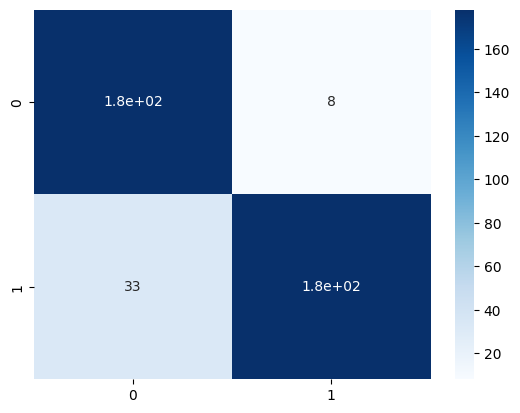

In [52]:
# pipeline
clf = Pipeline([('vec', CountVectorizer()),
                ('model', LinearSVC())])

# fit
clf.fit(X_train, y_train)

# predict eval data
pred_labels = clf.predict(X_test)
print(classification_report(y_test, pred_labels))


# conf mat
def make_conf_mat(orig_labels, pred_labels):
    labels = list(set(orig_labels))
    cnf_mat = confusion_matrix(orig_labels, pred_labels, labels=labels)
    df_conf_mat = pd.DataFrame(cnf_mat)
    df_conf_mat.columns = labels
    df_conf_mat.index = labels
    return df_conf_mat


df_conf_mat = make_conf_mat(y_test, pred_labels)
print(df_conf_mat)
sns.heatmap(df_conf_mat, cmap='Blues', annot=True)
plt.show()

              precision    recall  f1-score   support

           0       0.83      0.95      0.89       186
           1       0.95      0.83      0.89       211

    accuracy                           0.89       397
   macro avg       0.89      0.89      0.89       397
weighted avg       0.89      0.89      0.89       397

     0    1
0  176   10
1   35  176


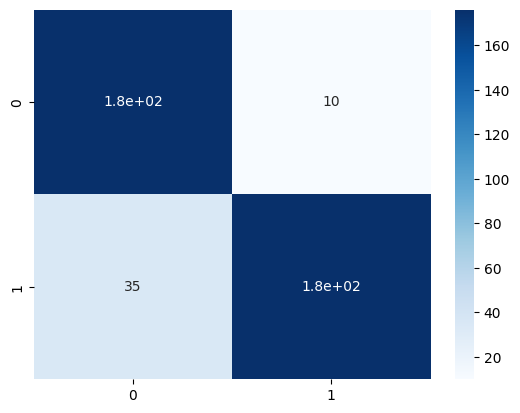

In [53]:
## accuracy of nn
print(classification_report(y_test, nn_preds))

df_conf_mat = make_conf_mat(y_test, nn_preds)
print(df_conf_mat)
sns.heatmap(df_conf_mat, cmap='Blues', annot=True)
plt.show()

In [36]:
## Use glove embeddings

## use embeddings

In [57]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import sentencepiece as spm

In [58]:
# Fetch 20newsgroups data
categories = ['sci.space', 'rec.sport.baseball']
newsgroups_data = fetch_20newsgroups(subset='all', categories=categories, remove=('headers', 'footers', 'quotes'))

# Train a SentencePiece tokenizer
with open("newsgroup_data.txt", "w") as f:
    for item in newsgroups_data.data:
        f.write("%s\n" % item)

spm.SentencePieceTrainer.train(input='newsgroup_data.txt', model_prefix='spm', vocab_size=5000)

# Load the trained tokenizer
sp = spm.SentencePieceProcessor()
sp.load('spm.model')

# Tokenize the data using SentencePiece
def tokenize_text(texts, sp_model, max_len=100):
    tokenized_texts = []
    for text in texts:
        tokens = sp_model.encode_as_ids(text)[:max_len]  # Tokenize and truncate to max_len
        if len(tokens) < max_len:
            tokens += [0] * (max_len - len(tokens))  # Padding with 0 if necessary
        tokenized_texts.append(tokens)
    return torch.tensor(tokenized_texts, dtype=torch.long)

# Prepare training and testing data
X_train, X_test, y_train, y_test = train_test_split(newsgroups_data.data, newsgroups_data.target, test_size=0.2, random_state=42)
X_train_tokens = tokenize_text(X_train, sp)
X_test_tokens = tokenize_text(X_test, sp)

# Encode labels
label_encoder = LabelEncoder()
y_train_enc = torch.tensor(label_encoder.fit_transform(y_train), dtype=torch.long)
y_test_enc = torch.tensor(label_encoder.transform(y_test), dtype=torch.long)

In [59]:
class LiquidTimeStep(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LiquidTimeStep, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.W_in = nn.Linear(input_size, hidden_size)
        self.W_h = nn.Linear(hidden_size, hidden_size)
        self.tau = nn.Parameter(torch.ones(hidden_size))

    def forward(self, x, h):
        dx = torch.tanh(self.W_in(x) + self.W_h(h))
        h_new = h + (dx - h) / self.tau
        return h_new

class LiquidNeuralNetwork(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size, max_len=100):
        super(LiquidNeuralNetwork, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)  # Embedding layer
        self.hidden_size = hidden_size
        self.max_len = max_len
        self.liquid_step = LiquidTimeStep(embedding_dim, hidden_size)
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size, seq_len = x.size()  # Get the batch size and sequence length
        x = self.embedding(x)  # Convert input tokens to embeddings
        h = torch.zeros(batch_size, self.hidden_size, device=x.device)  # Initialize hidden state
        for t in range(seq_len):
            h = self.liquid_step(x[:, t, :], h)  # Process each time step
        output = self.output_layer(h)  # Output based on the final hidden state
        return output


In [64]:
# Hyperparameters
vocab_size = 5000  # Vocabulary size from SentencePiece
embedding_dim = 300  # Embedding size
hidden_size = 20  # Number of hidden units
output_size = 2   # Binary classification (sci.space and rec.sport.baseball)

# Create the model
model = LiquidNeuralNetwork(vocab_size, embedding_dim, hidden_size, output_size)

# Define Loss and optimizer
criterion = nn.CrossEntropyLoss()  # For classification
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [65]:
# Training Loop
num_epochs = 30
batch_size = 32

def train(model, X_train, y_train, criterion, optimizer, batch_size):
    model.train()
    total_samples = X_train.shape[0]
    num_batches = total_samples // batch_size

    for epoch in range(num_epochs):
        for i in range(num_batches):
            # Get batch of data
            start = i * batch_size
            end = start + batch_size
            inputs = X_train[start:end]
            labels = y_train[start:end]

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Calculate loss
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

train(model, X_train_tokens, y_train_enc, criterion, optimizer, batch_size)

Epoch [1/30], Loss: 0.7199
Epoch [2/30], Loss: 0.6527
Epoch [3/30], Loss: 0.5673
Epoch [4/30], Loss: 0.4789
Epoch [5/30], Loss: 0.3810
Epoch [6/30], Loss: 0.3140
Epoch [7/30], Loss: 0.2589
Epoch [8/30], Loss: 0.2474
Epoch [9/30], Loss: 0.2130
Epoch [10/30], Loss: 0.2180
Epoch [11/30], Loss: 0.2312
Epoch [12/30], Loss: 0.2238
Epoch [13/30], Loss: 0.2353
Epoch [14/30], Loss: 0.2292
Epoch [15/30], Loss: 0.2192
Epoch [16/30], Loss: 0.2253
Epoch [17/30], Loss: 0.2429
Epoch [18/30], Loss: 0.2122
Epoch [19/30], Loss: 0.2022
Epoch [20/30], Loss: 0.1756
Epoch [21/30], Loss: 0.1794
Epoch [22/30], Loss: 0.2096
Epoch [23/30], Loss: 0.2077
Epoch [24/30], Loss: 0.1756
Epoch [25/30], Loss: 0.1616
Epoch [26/30], Loss: 0.1776
Epoch [27/30], Loss: 0.2231
Epoch [28/30], Loss: 0.1863
Epoch [29/30], Loss: 0.1251
Epoch [30/30], Loss: 0.1738


In [66]:
nn_preds=evaluate(model, X_test_tokens, y_test_enc)

Test Accuracy: 49.62%


              precision    recall  f1-score   support

           0       0.47      0.63      0.54       186
           1       0.54      0.38      0.44       211

    accuracy                           0.50       397
   macro avg       0.50      0.50      0.49       397
weighted avg       0.51      0.50      0.49       397

     0   1
0  117  69
1  131  80


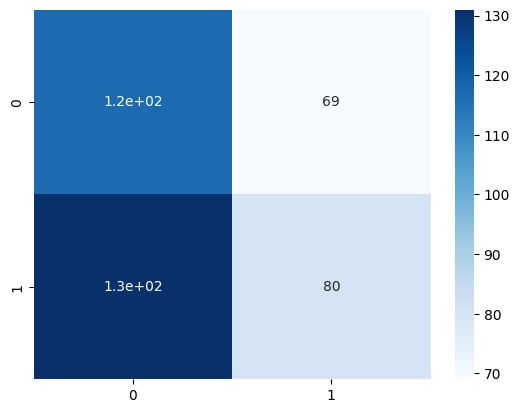

In [67]:
## accuracy of nn
print(classification_report(y_test, nn_preds))

df_conf_mat = make_conf_mat(y_test, nn_preds)
print(df_conf_mat)
sns.heatmap(df_conf_mat, cmap='Blues', annot=True)
plt.show()

## Example from here: https://ncps.readthedocs.io/en/latest/examples/torch_first_steps.html

In [1]:
!pip install seaborn ncps torch pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 kB 859.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 19.0 MB/s eta 0:00:00


In [2]:
import numpy as np
import torch.nn as nn
from ncps.wirings import AutoNCP
from ncps.torch import LTC
import pytorch_lightning as pl
import torch
import torch.utils.data as data

### generate data

data_x.shape:  (1, 48, 2)
data_y.shape:  (1, 48, 1)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


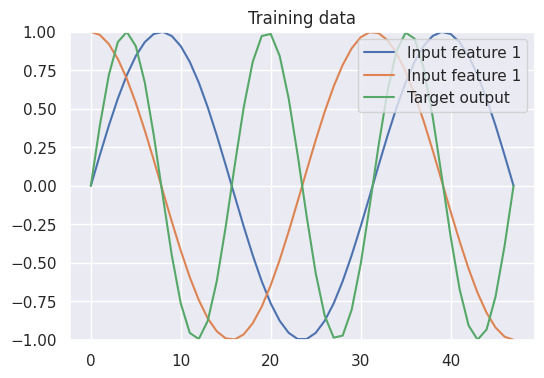

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
N = 48 # Length of the time-series
# Input feature is a sine and a cosine wave
data_x = np.stack(
    [np.sin(np.linspace(0, 3 * np.pi, N)), np.cos(np.linspace(0, 3 * np.pi, N))], axis=1
)
data_x = np.expand_dims(data_x, axis=0).astype(np.float32)  # Add batch dimension
# Target output is a sine with double the frequency of the input signal
data_y = np.sin(np.linspace(0, 6 * np.pi, N)).reshape([1, N, 1]).astype(np.float32)
print("data_x.shape: ", str(data_x.shape))
print("data_y.shape: ", str(data_y.shape))
data_x = torch.Tensor(data_x)
data_y = torch.Tensor(data_y)
dataloader = data.DataLoader(
    data.TensorDataset(data_x, data_y), batch_size=1, shuffle=True, num_workers=4
)

# Let's visualize the training data
sns.set()
plt.figure(figsize=(6, 4))
plt.plot(data_x[0, :, 0], label="Input feature 1")
plt.plot(data_x[0, :, 1], label="Input feature 1")
plt.plot(data_y[0, :, 0], label="Target output")
plt.ylim((-1, 1))
plt.title("Training data")
plt.legend(loc="upper right")
plt.show()

In [4]:
# LightningModule for training a RNNSequence module
class SequenceLearner(pl.LightningModule):
    def __init__(self, model, lr=0.005):
        super().__init__()
        self.model = model
        self.lr = lr

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        return {"loss": loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)

        self.log("val_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        # Here we just reuse the validation_step for testing
        return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

In [5]:
out_features = 1
in_features = 2

wiring = AutoNCP(16, out_features)  # 16 units, 1 motor neuron

ltc_model = LTC(in_features, wiring, batch_first=True)
learn = SequenceLearner(ltc_model, lr=0.01)
trainer = pl.Trainer(
    logger=pl.loggers.CSVLogger("log"),
    max_epochs=400,
    gradient_clip_val=1,  # Clip gradient to stabilize training
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


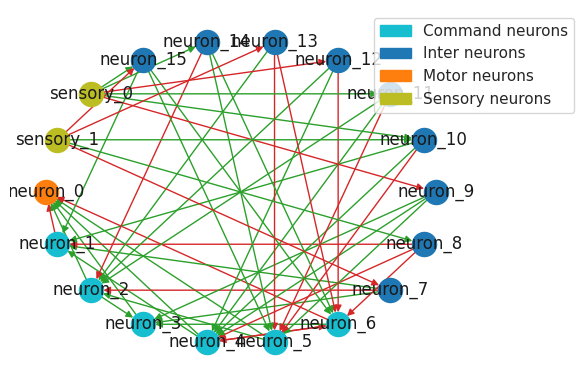

In [6]:
#Draw the wiring diagram of the network
sns.set_style("white")
plt.figure(figsize=(6, 4))
legend_handles = wiring.draw_graph(draw_labels=True, neuron_colors={"command": "tab:cyan"})
plt.legend(handles=legend_handles, loc="upper center", bbox_to_anchor=(1, 1))
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()


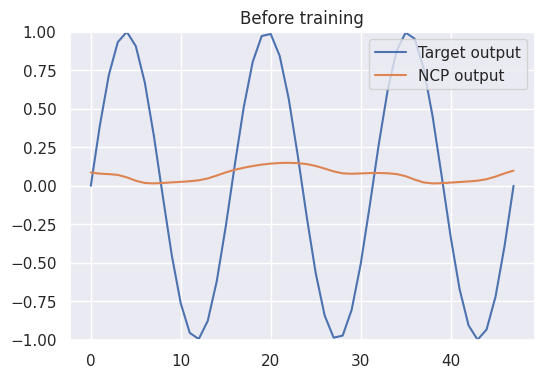

In [7]:
#before training
# Let's visualize how LTC initialy performs before the training
sns.set()
with torch.no_grad():
    prediction = ltc_model(data_x)[0].numpy()
plt.figure(figsize=(6, 4))
plt.plot(data_y[0, :, 0], label="Target output")
plt.plot(prediction[0, :, 0], label="NCP output")
plt.ylim((-1, 1))
plt.title("Before training")
plt.legend(loc="upper right")
plt.show()

In [8]:
#train
trainer.fit(learn, dataloader)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | LTC  | 1.5 K  | train
---------------------------------------
1.2 K     Trainable params
288       Non-trainable params
1.5 K     Total params
0.006     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=400` reached.


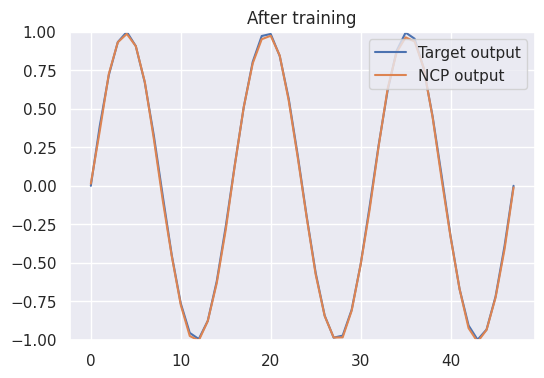

In [9]:
# How does the trained model now fit to the sinusoidal function?
sns.set()
with torch.no_grad():
    prediction = ltc_model(data_x)[0].numpy()
plt.figure(figsize=(6, 4))
plt.plot(data_y[0, :, 0], label="Target output")
plt.plot(prediction[0, :, 0], label="NCP output")
plt.ylim((-1, 1))
plt.title("After training")
plt.legend(loc="upper right")
plt.show()